In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/NIFTY50.csv


In [24]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline

In [25]:
data = pd.read_csv("/kaggle/input/dataset/NIFTY50.csv")
data

,DATE,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED
0,2015-11-09,7788.25,7937.75,7915.20,7771.70,2.184224e+08
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,1.702674e+08
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,2.238044e+07
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,1.658768e+08
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,1.541349e+08
...,...,...,...,...,...,...
2127,2024-06-04,23179.50,23179.50,21884.50,21281.45,1.006105e+09
2128,2024-06-05,22128.35,22670.40,22620.35,21791.95,6.384871e+08
2129,2024-06-06,22798.60,22910.15,22821.40,22642.60,4.804133e+08
2130,2024-06-07,22821.85,23320.20,23290.15,22789.05,4.735549e+08


In [26]:
data.dropna(inplace=True)

In [27]:
data['DATE']=pd.to_datetime(data['DATE'])

In [61]:
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]

In [29]:
train

,DATE,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED
0,2015-11-09,7788.25,7937.75,7915.20,7771.70,218422388.0
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,170267413.0
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,22380435.0
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,165876819.0
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,154134885.0
...,...,...,...,...,...,...
1700,2022-09-21,17766.35,17838.70,17718.35,17663.60,245532498.0
1701,2022-09-22,17609.65,17722.75,17629.80,17532.45,284094023.0
1702,2022-09-23,17593.85,17642.15,17327.35,17291.65,390754862.0
1703,2022-09-26,17156.30,17196.40,17016.30,16978.30,492002942.0


In [30]:
data.dtypes

DATE             datetime64[ns]
OPEN                    float64
HIGH                    float64
CLOSE                   float64
LOW                     float64
SHARES_TRADED           float64
dtype: object

<Figure size 2000x1400 with 0 Axes>

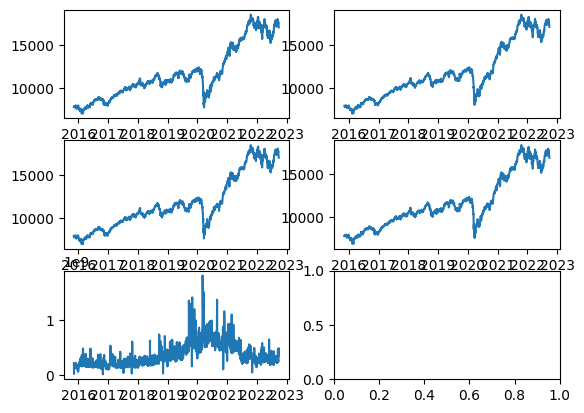

In [31]:
plt.figure(figsize=(20,14))
figure, axes = plt.subplots(nrows=3,ncols=2)
axes[0,0].plot(train['DATE'],train['OPEN'],label= 'Open')
axes[0,1].plot(train['DATE'],train['HIGH'],label= 'High')
axes[1,0].plot(train['DATE'],train['CLOSE'],label= 'Close')
axes[1,1].plot(train['DATE'],train['LOW'],label= 'Low')
axes[2,0].plot(train['DATE'],train['SHARES_TRADED'],label= 'Shares_Traded')

In [32]:
train.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)
train.head()

/tmp/ipykernel_34/3059741884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,y,LOW,SHARES_TRADED
0,2015-11-09,7788.25,7937.75,7915.20,7771.70,218422388.0
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,170267413.0
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,22380435.0
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,165876819.0
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,154134885.0


In [33]:
test.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)
test.head()

/tmp/ipykernel_34/3526546813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,y,LOW,SHARES_TRADED
1705,2022-09-28,16870.55,17037.60,16858.60,16820.40,323922457.0
1706,2022-09-29,16993.60,17026.05,16818.10,16788.60,340034380.0
1707,2022-09-30,16798.05,17187.10,17094.35,16747.70,380204763.0
1708,2022-10-03,17102.10,17114.65,16887.35,16855.55,285850587.0
1709,2022-10-04,17147.45,17287.30,17274.30,17117.30,231601639.0


In [34]:
model = Prophet()
model.add_regressor("OPEN",standardize=False)
model.add_regressor("HIGH",standardize=False)
model.add_regressor("LOW",standardize=False)
model.add_regressor("SHARES_TRADED",standardize=False)
model.fit(train)

18:37:30 - cmdstanpy - INFO - Chain [1] start processing
18:37:30 - cmdstanpy - INFO - Chain [1] done processing
18:37:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
18:37:30 - cmdstanpy - INFO - Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
model.params

OrderedDict([('lp__', array([[9693.26]])),
             ('k', array([[-0.0322211]])),
             ('m', array([[0.00214004]])),
             ('delta',
              array([[ 5.46955e-02, -2.68227e-02, -7.38121e-06, -3.39171e-07,
                       1.46516e-02,  2.18059e-08, -1.15597e-02,  1.75693e-08,
                       3.11794e-08,  5.39444e-03,  7.73999e-07,  4.24026e-08,
                      -5.17271e-03,  1.25639e-08,  9.54975e-04, -6.90747e-10,
                       5.14471e-07, -1.24599e-02, -1.75243e-02,  5.52426e-02,
                      -5.20136e-08,  2.22039e-02, -7.79299e-02,  5.77643e-02,
                      -3.06754e-02]])),
             ('sigma_obs', array([[0.00204344]])),
             ('beta',
              array([[-8.38954e-05,  1.10301e-04,  1.46792e-04,  1.06736e-04,
                      -8.21912e-05,  2.77217e-06,  5.33216e-05,  7.79282e-05,
                       1.01870e-04,  7.20962e-05, -9.97650e-05,  4.05457e-05,
                       5.24813e-0

In [62]:
test.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)
test.head()

/tmp/ipykernel_34/3526546813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'CLOSE':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,y,LOW,SHARES_TRADED
1705,2022-09-28,16870.55,17037.60,16858.60,16820.40,323922457.0
1706,2022-09-29,16993.60,17026.05,16818.10,16788.60,340034380.0
1707,2022-09-30,16798.05,17187.10,17094.35,16747.70,380204763.0
1708,2022-10-03,17102.10,17114.65,16887.35,16855.55,285850587.0
1709,2022-10-04,17147.45,17287.30,17274.30,17117.30,231601639.0


In [63]:
test1 = test[['ds','OPEN','HIGH','LOW','SHARES_TRADED']]

In [64]:
forecast= model.predict(test1)

In [65]:
forecast = forecast[['ds','yhat']]
forecast.head()

,ds,yhat
0,2022-09-28,16975.415071
1,2022-09-29,16849.396081
2,2022-09-30,17109.528295
3,2022-10-03,16911.032555
4,2022-10-04,17242.087880


In [66]:
final_df = pd.merge(test, forecast, on='ds', how='left')
final_df

,ds,OPEN,HIGH,y,LOW,SHARES_TRADED,yhat
0,2022-09-28,16870.55,17037.60,16858.60,16820.40,3.239225e+08,16975.415071
1,2022-09-29,16993.60,17026.05,16818.10,16788.60,3.400344e+08,16849.396081
2,2022-09-30,16798.05,17187.10,17094.35,16747.70,3.802048e+08,17109.528295
3,2022-10-03,17102.10,17114.65,16887.35,16855.55,2.858506e+08,16911.032555
4,2022-10-04,17147.45,17287.30,17274.30,17117.30,2.316016e+08,17242.087880
...,...,...,...,...,...,...,...
434,2024-06-04,23179.50,23179.50,21884.50,21281.45,1.006105e+09,21665.101442
435,2024-06-05,22128.35,22670.40,22620.35,21791.95,6.384871e+08,22329.687762
436,2024-06-06,22798.60,22910.15,22821.40,22642.60,4.804133e+08,22731.500723
437,2024-06-07,22821.85,23320.20,23290.15,22789.05,4.735549e+08,23213.407752


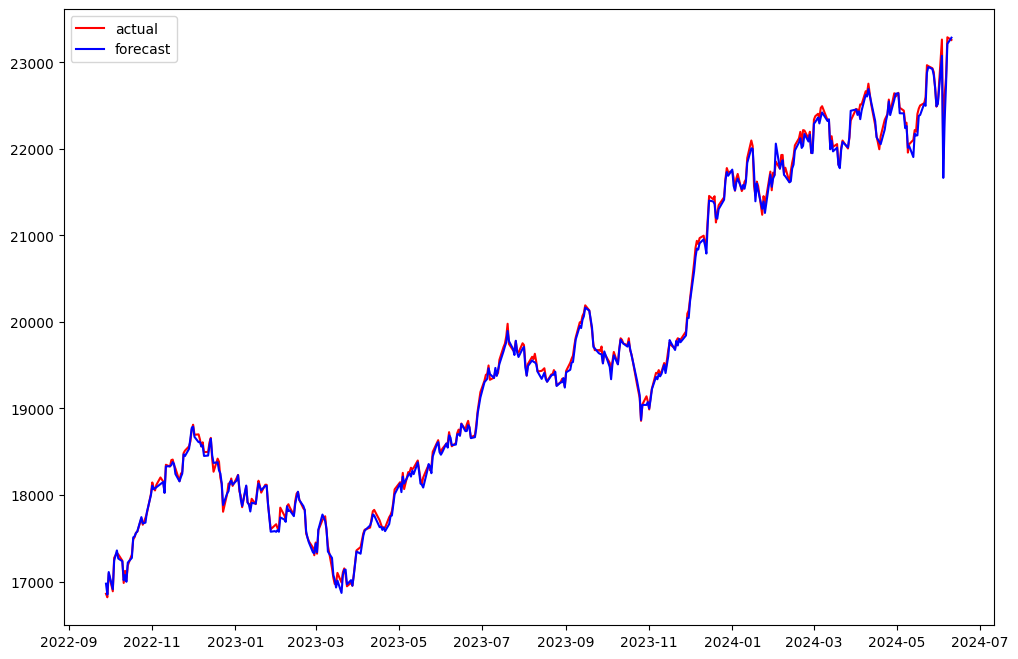

In [69]:
plt.figure(figsize=(12,8))
plt.plot(final_df['ds'],final_df['y'],color='red',label='actual')
plt.plot(final_df['ds'],final_df['yhat'],color='blue',label='forecast')
plt.legend()

In [70]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [71]:
mape=mean_absolute_percentage_error(final_df['y'], final_df['yhat'])
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(final_df['y'], final_df['yhat'])
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)

Mean Absolute Percentage Error 0.002125296552924091
Mean Squared Error 3195.4025133828773
RMSE 56.52789146415137


In [73]:
output=pd.DataFrame()
output['Test']=final_df['y']
output['Prediction']=final_df['yhat']
output['Difference']=output['Test']-output['Prediction']
output['% Chnage']=abs(output['Difference']/output['Test'])*100
output

,Test,Prediction,Difference,% Chnage
0,16858.60,16975.415071,-116.815071,0.692911
1,16818.10,16849.396081,-31.296081,0.186086
2,17094.35,17109.528295,-15.178295,0.088791
3,16887.35,16911.032555,-23.682555,0.140238
4,17274.30,17242.087880,32.212120,0.186474
...,...,...,...,...
434,21884.50,21665.101442,219.398558,1.002529
435,22620.35,22329.687762,290.662238,1.284959
436,22821.40,22731.500723,89.899277,0.393925
437,23290.15,23213.407752,76.742248,0.329505


In [74]:
output.describe()

,Test,Prediction,Difference,% Chnage
count,439.000000,439.000000,439.000000,439.000000
mean,19637.475399,19610.093722,27.381677,0.212530
std,1785.763339,1772.920507,49.509897,0.178890
min,16818.100000,16849.396081,-207.212754,0.000084
25%,18120.525000,18108.625006,0.961904,0.081907
50%,19413.750000,19391.096554,27.221094,0.176674
75%,21519.725000,21528.310693,52.136466,0.289090
max,23290.150000,23285.363237,290.662238,1.284959
